### Imports

In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import measure

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/"
data_path = base_path + "2021_03_25/"
# data_path = base_path + "2021_03_29/"

tiff_path = os.path.join(data_path, "noise_tiffs")
rec_path = os.path.join(data_path, "recs")

ex_prefix = "cell2_400um_25um_seed"
# ex_prefix = "cell2_800um_25um_seed"

### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [4]:
raw_noise = np.stack(
    [
        io.imread(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ], 
    axis=0
)
raw_noise = raw_noise.transpose(0, 1, 3, 2) / 255

# physical dimensions (microns)
stim_width = 400
stim_height = 400

# 60Hz for 60s after 10s delay
n_seeds, noise_frames, noise_cols, noise_rows = raw_noise.shape
noise_xaxis = np.arange(noise_frames) * (1 / 60) + 10.

print("raw noise shape:", raw_noise.shape)

raw noise shape: (3, 18000, 16, 16)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


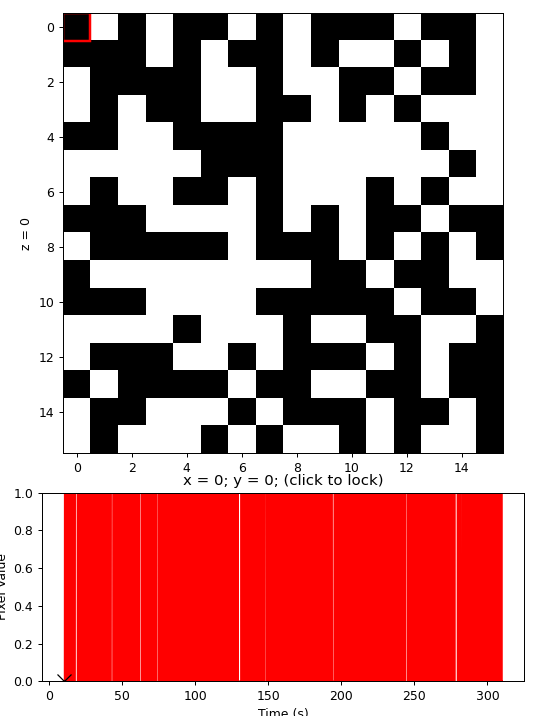

In [5]:
raw_noise_plot = StackExplorer(
    raw_noise[0],
    zaxis=noise_xaxis,
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")
raw_noise_plot.fig.show()

In [6]:
raw_recs = {}
for f in os.listdir(rec_path):
    if f.startswith(ex_prefix):
        seed, _trial = re.split(r"_", f[len(ex_prefix):])
        seed = int(seed)
        with h5.File(os.path.join(rec_path, f), "r") as hdf:
            ex = unpack_hdf(hdf)
            rs = [
                np.squeeze(s["analogScans"]) 
                for k, s in ex.items() if k.startswith("sweep")
            ]
        if seed in raw_recs:
            for r in rs:
                raw_recs[seed].append(r)
        else:
            raw_recs[seed] = rs
            
raw_recs = np.stack([r for r in raw_recs.values()], axis=0).astype(np.float)
_, n_trials, n_pts = raw_recs.shape
raw_avg_recs = np.mean(raw_recs, axis=1)
recs_xaxis = np.arange(n_pts) * .0001
print("recs shape:", raw_recs.shape)
print("avg recs shape:", raw_avg_recs.shape)

recs shape: (3, 2, 3300000)
avg recs shape: (3, 3300000)


### Normalize recordings
Subtract out the baseline, and divide by the max value, for each recording so that each of them are from 0 to 1.

In [7]:
stim_start = nearest_index(recs_xaxis, 10)

recs = raw_recs * -1
recs -= np.mean(recs[:, :, 0:stim_start], axis=2).reshape(*recs.shape[:2], 1)
recs /= np.max(recs, axis=2).reshape(*recs.shape[:2], 1)

avg_recs = raw_avg_recs * -1
avg_recs -= np.mean(avg_recs[:, 0:stim_start], axis=1).reshape(avg_recs.shape[0], 1)
avg_recs /= np.max(avg_recs, axis=1).reshape(avg_recs.shape[0], 1)

### Signal de-trending

In [8]:
# width = 10000
width = 500

trend = np.stack(
    [
        moving_avg(r, width) 
        for r in recs.reshape(np.prod(recs.shape[:2]).astype(np.int), -1)
    ],
    axis=0
).reshape(*recs.shape)
detrend = recs - trend

avg_trend = np.stack([moving_avg(r, width) for r in avg_recs], axis=0)
avg_detrend = avg_recs - avg_trend

detrend_mode = True

### Example of detrended signal

<IPython.core.display.Javascript object>


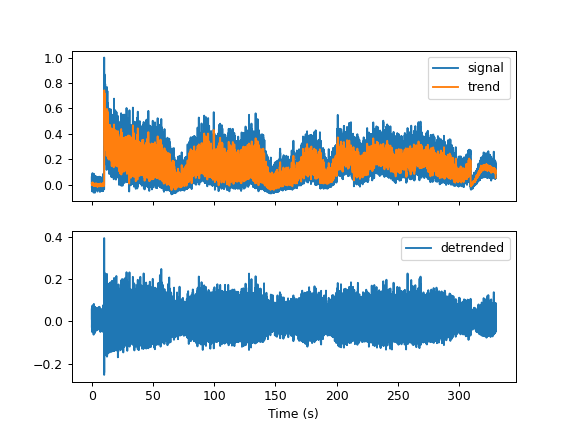

In [9]:
trend_fig, trend_ax = plt.subplots(2, sharex=True)
trend_ax[0].plot(recs_xaxis, recs[0, 0], label="signal")
trend_ax[0].plot(recs_xaxis, trend[0, 0], label="trend")
trend_ax[1].plot(recs_xaxis, detrend[0, 0], label="detrended")

trend_ax[1].set_xlabel("Time (s)")
for a in trend_ax:
    a.legend()

### Explore signals from trials, and peak finding parameters
Use scroll wheel to cycle between trials, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates

A separate explorer for each seed is generated here. We need to keep references to the figures to keep them alive, so we store them in a list.

<IPython.core.display.Javascript object>


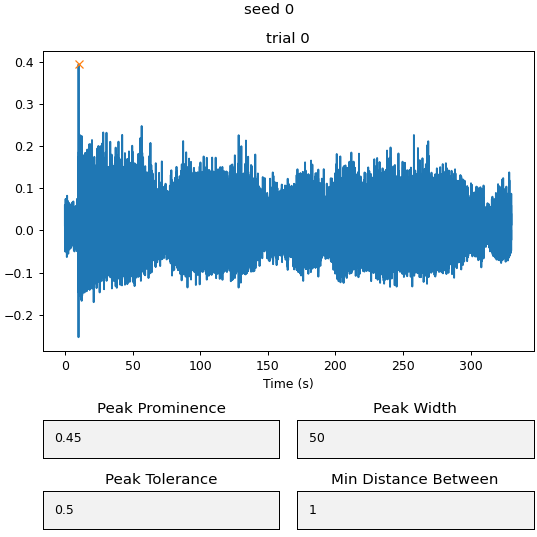

<IPython.core.display.Javascript object>


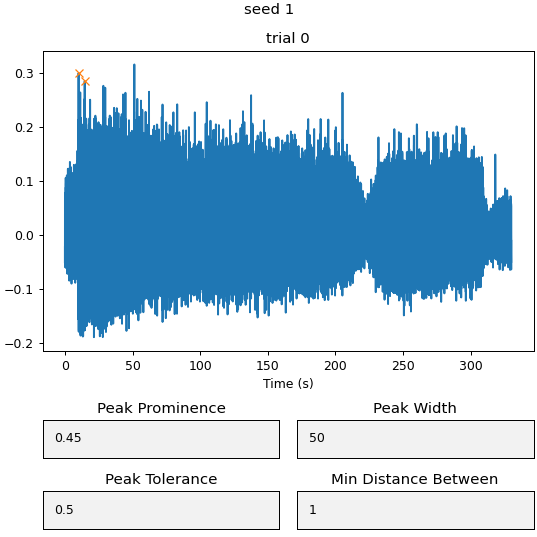

<IPython.core.display.Javascript object>


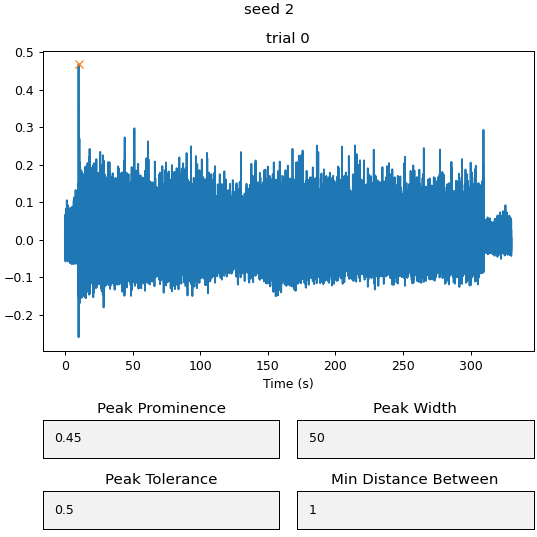

In [10]:
explorers = []
for seed in range(n_seeds):
    explorers.append(
        PeakExplorer(
            recs_xaxis, 
            detrend[seed] if detrend_mode else recs[seed],
            prominence=.45,
            width=50,
            tolerance=.5,
            distance=1,
            title_fmt_fun=lambda i: "trial %i" % i,
        )
    )
    explorers[-1].fig.suptitle("seed %i" % seed)

### Create response triggered averages of stimulus movie for each noise seed.
- `lead` sets the time (in seconds) to use preceding each threshold passing event.
- peak finding parameters correspond to those above, set them here in order to influence the stimulus triggered window calculation.
- `max_prominence` sets a clip off point for peaks, such that errantly large events do not completely wash out the rest (due to prominence scaling using softmax). This is optional, and can be set to `None` or commented out from the arguments given to `avg_trigger_window`.

In [11]:
lead = 5.0             # length of triggered average movie (seconds before peak)
prominence = 0.45      # difference between peaks and their surroundings
peak_width = 50        # minimum number of points (within tolerance)
peak_tolerance = 0.5   # ratio value can drop from peak within width
min_peak_interval = 1  # number of points required between peaks
max_prominence = 0.7   # clip to avoid dominance by errant peaks
start_time = 30        # time to begin using peaks for triggered average
end_time = None        # cutoff time for considering peaks

lead_frames = nearest_index(noise_xaxis, np.min(noise_xaxis) + lead)
lead_stacks, legal_idxs = [], []

# add avg_recs to end, then split out the results to decrease duplication
if detrend_mode:
    combined_recs = np.concatenate([detrend, np.expand_dims(avg_detrend, 1)], axis=1)
    prominence = .29
    peak_width = 30
else:
    combined_recs = np.concatenate([recs, np.expand_dims(avg_recs, 1)], axis=1)

for seed in range(n_seeds):
    # find peaks for each trial for the current seed
    peak_idxs, peak_proms = find_peaks(
        combined_recs[seed, :],
        prominence=prominence,
        width=peak_width,
        rel_height=peak_tolerance,
        distance=min_peak_interval
    )
    
    # generate lead windows for each of the trials calculated above and store the
    # legal idxs (falling the the correct time window) that were actually used
    windows, legals = [], []
    for j in range(combined_recs.shape[1]):
        trig, idxs = avg_trigger_window(
            noise_xaxis, 
            raw_noise[seed],
            recs_xaxis,
            combined_recs[seed][j],
            lead,
            peak_idxs[j],
            prominences=peak_proms[j],
            max_prominence=max_prominence,
            nonlinear_weighting=True,
            start_time=start_time,
            end_time=end_time,
        )
        windows.append(trig)
        legals.append(idxs)
    
    lead_stacks.append(np.stack(windows, axis=0))
    legal_idxs.append(legals)  # ragged lenghts, cannot be stored as array

del combined_recs

# split trial and average output (avg is last of zeroth axis, as in combined_recs)
avg_lead_stacks = np.stack([l[-1] for l in lead_stacks], axis=0)
lead_stacks = np.stack([l[:-1] for l in lead_stacks], axis=0)
avg_legal_idxs = [l[-1] for l in legal_idxs]
legal_idxs = [l[:-1] for l in legal_idxs]

# shape of lead_stacks is [n_seeds, n_trials, lead_frames, n_cols, n_rows]
mean_lead_stacks = np.mean(lead_stacks, axis=1)
lead_xaxis = np.linspace(lead_frames * (-1 / 60), 0, lead_frames)

### Display the threshold triggered stimuli for each noise seed separately.

<IPython.core.display.Javascript object>


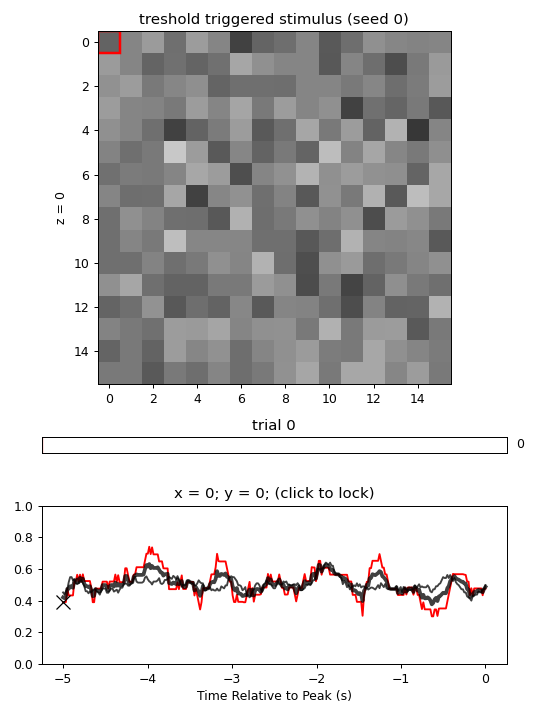

<IPython.core.display.Javascript object>


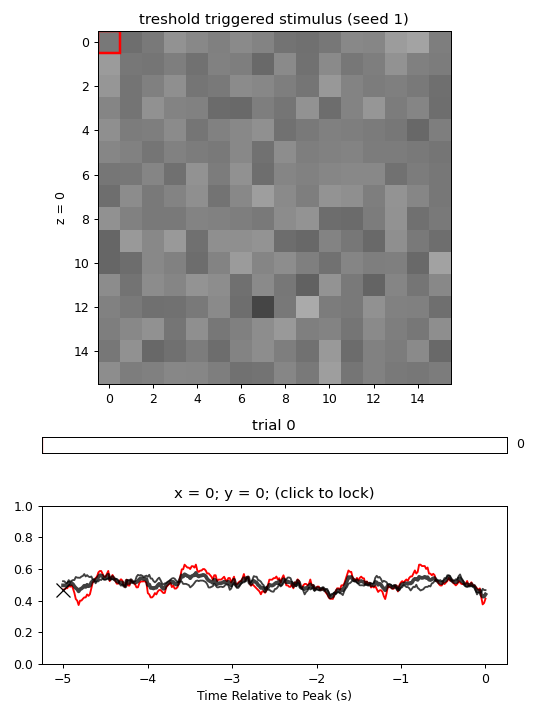

<IPython.core.display.Javascript object>


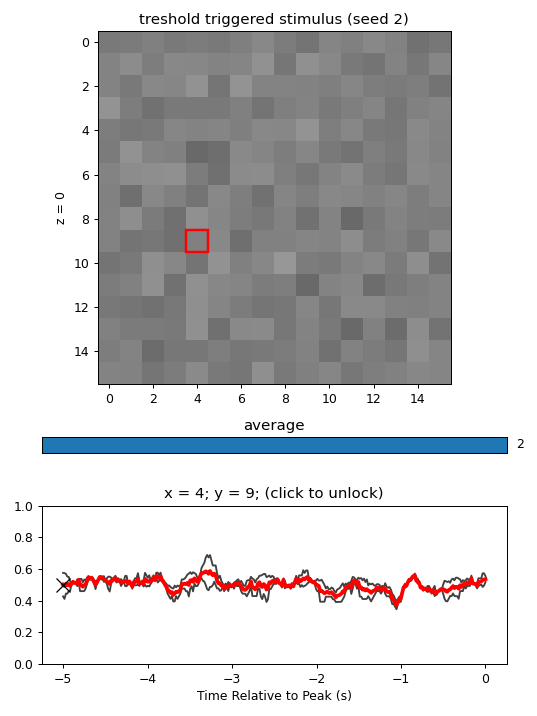

In [12]:
lead_stack_plots = []
for seed in range(lead_stacks.shape[0]):
    lead_stack_plots.append(
        StackExplorer(
            np.squeeze(lead_stacks[seed]),
            zaxis=lead_xaxis,
            delta=1,
            roi_sz=1,
            vmin=0,
            vmax=1,
            figsize=(6, 8)
        )
    )
    lead_stack_plots[-1].stack_ax.set_title("treshold triggered stimulus (seed %i)" % seed)
    lead_stack_plots[-1].beam_ax.set_xlabel("Time Relative to Peak (s)")
    lead_stack_plots[-1].fig.tight_layout()
    lead_stack_plots[-1].fig.show()

### Display the mean threshold triggered stimulus for each of each noise seed.
Compare the calculated triggered stimuli corresponding to each noise movie using `StackExplorer`.

<IPython.core.display.Javascript object>


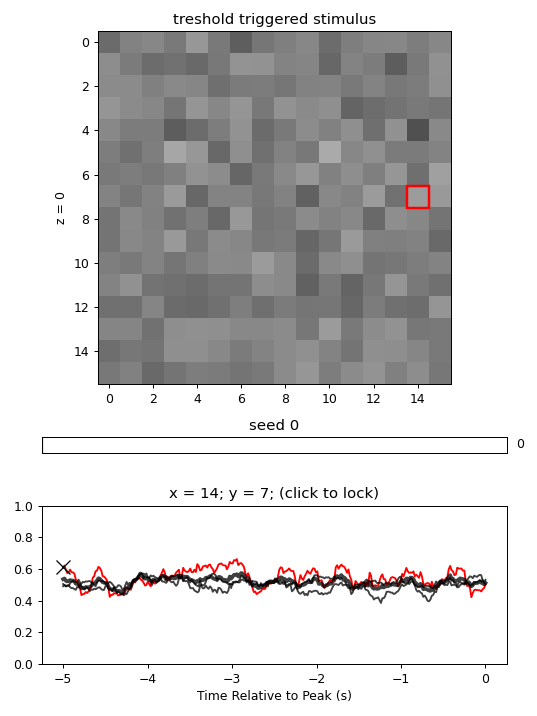

In [13]:
mean_lead_stack_plot = StackExplorer(
    mean_lead_stacks,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    slide_fmt_fun=lambda i: "seed %i" % i,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)

mean_lead_stack_plot.stack_ax.set_title("treshold triggered stimulus")
mean_lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
mean_lead_stack_plot.fig.tight_layout()
mean_lead_stack_plot.fig.show()

### Fourier analysis of somatic current recordings 

<IPython.core.display.Javascript object>


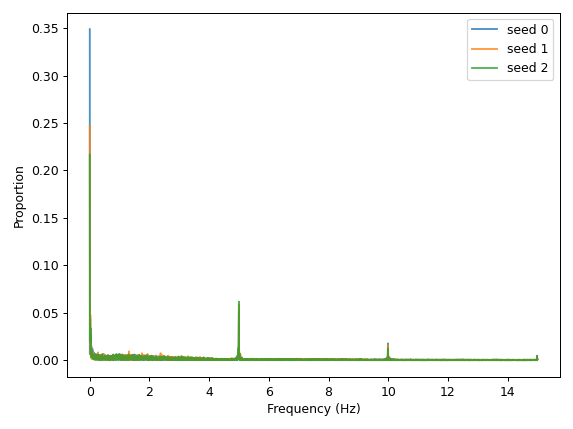

In [14]:
recs_dt = (np.max(recs_xaxis) - np.min(recs_xaxis)) / recs_xaxis.size
fft_xaxis = np.fft.fftfreq(n_pts, recs_dt)
end_idx = nearest_index(fft_xaxis, 15)

recs_fft = np.stack([np.fft.fft(beam) for beam in avg_recs], axis=0) 
recs_fft = 2.0 / n_pts * np.abs(recs_fft)

recs_fft_fig, recs_fft_ax = plt.subplots(1)
for i, ff in enumerate(recs_fft):
    recs_fft_ax.plot(fft_xaxis[:end_idx], ff[:end_idx], label="seed %i" % i, alpha=.8)

recs_fft_ax.set_ylabel("Proportion")
recs_fft_ax.set_xlabel("Frequency (Hz)")
recs_fft_ax.legend()
recs_fft_fig.tight_layout()

### Cross seed variance analysis

<IPython.core.display.Javascript object>


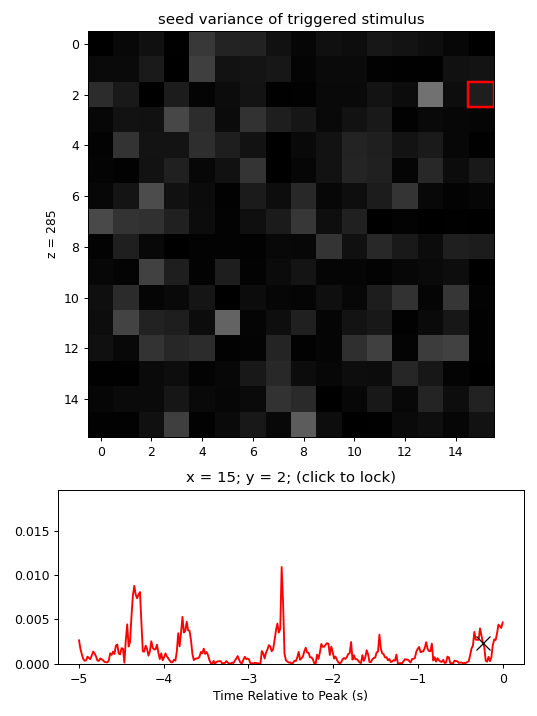

In [16]:
lead_seed_var = np.var(mean_lead_stacks, axis=0)
# lead_seed_var = np.var(mean_lead_stacks[1:], axis=0)

lead_seed_var_plot = StackExplorer(
    lead_seed_var,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    slide_fmt_fun=lambda i: "seed %i" % i,
    vmin=0,
    vmax=np.max(lead_seed_var),
    figsize=(6, 8)
)

lead_seed_var_plot.stack_ax.set_title("seed variance of triggered stimulus")
lead_seed_var_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_seed_var_plot.fig.tight_layout()
lead_seed_var_plot.fig.show()

### Quality index of triggered stimulus (across seeds)

<IPython.core.display.Javascript object>


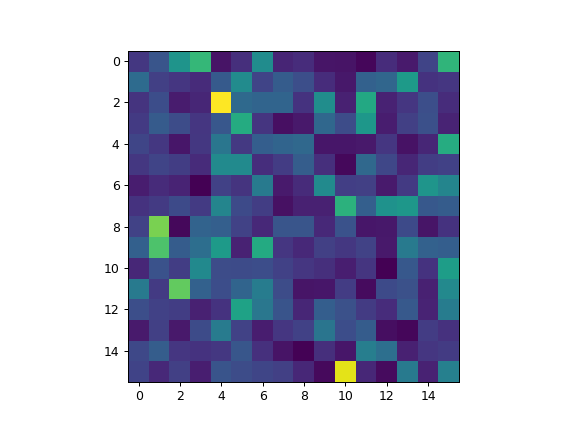

In [22]:
win_start = nearest_index(lead_xaxis, -1)
win_end = nearest_index(lead_xaxis, 0)

seed_mean_lead_stack = np.mean(mean_lead_stacks, axis=0)
qi = (
    np.var(seed_mean_lead_stack[win_start:win_end], axis=0) 
    / np.mean(lead_seed_var[win_start:win_end], axis=0)
)

cross_seed_qi_fig, cross_seed_qi_ax = plt.subplots(1)
cross_seed_qi_ax.imshow(qi)